In [1]:
from matplotlib import pyplot as plt
import numpy as np
import gzip
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import utils

%matplotlib inline

In [2]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

# Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

In [3]:
# Adjust data path:
data_path = '../../data/notmnist/'

train_data = extract_data(data_path+'train-images-idx3-ubyte.gz', 6000)
test_data = extract_data(data_path+'t10k-images-idx3-ubyte.gz', 1000)

train_labels = extract_labels(data_path+'train-labels-idx1-ubyte.gz',6000)
test_labels = extract_labels(data_path+'t10k-labels-idx1-ubyte.gz',1000)

X_train = train_data.reshape(-1, 28,28, 1)  # add grey channel
X_test = test_data.reshape(-1, 28,28, 1)

n_classes = 10
Y_train = utils.to_categorical(train_labels, n_classes) # 1-hot
Y_test = utils.to_categorical(test_labels, n_classes)
print(Y_train[:10])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [4]:
# Shape of training set
print("Training set (images) shape: {shape}".format(shape=X_train.shape))
# Shape of test set
print("Test set (images) shape: {shape}".format(shape=X_test.shape))
# Type of data - should be float32
print('data type: ', X_train.dtype, X_test.dtype)

Training set (images) shape: (6000, 28, 28, 1)
Test set (images) shape: (1000, 28, 28, 1)
data type:  float32 float32


Text(0.5, 1.0, '(Label: I)')

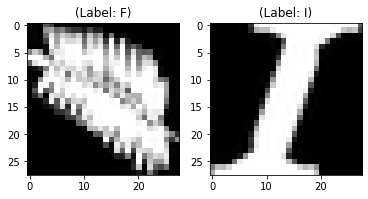

In [5]:
# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(X_train[0], (28,28))
curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(X_test[0], (28,28))
curr_lbl = test_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [6]:
# rescale the data in range 0-1
X_train = X_train / 255.0
X_test = X_test / 255.0

## Create a shallow MLP encoder

In [7]:
X_train.shape

(6000, 28, 28, 1)

In [8]:
28 * 28

784

In [9]:
# STARTING FROM HERE, COMPLETE THE CODE WHERE YOU SEE ...
# size of our encoded representation
encoding_dim = 32  # this is the number of neurons you chose to encode

# define input layer, encoded layer and decoded layer
input_img = Input(shape=(784))
encoded = Dense(encoding_dim, activation='sigmoid')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

# define autoencoder model 
autoencoder = Model(inputs=input_img, outputs=decoded)
encoder = Model(inputs=input_img, outputs=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1](encoded_input)

# create the decoder model
decoder = Model(inputs=encoded_input, outputs=decoder_layer)

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [10]:
# compile the network - use adam optimizer, beware to use the good loss function
autoencoder.compile(loss='mse', optimizer='adam')

In [15]:
# for visualisation
def plot_result(x_test,decoded_imgs):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [12]:
X_train_flat = X_train.reshape(6000,784)
X_test_flat = X_test.reshape(1000,784)

In [13]:
# train the network
log = autoencoder.fit(X_train_flat, X_train_flat, validation_data=(X_test_flat, X_test_flat),
                     batch_size=32, epochs=50)

Train on 6000 samples, validate on 1000 samples
Epoch 1/50
6000/6000 [==============================] - 1s 178us/sample - loss: 0.1752 - val_loss: 0.1523
Epoch 2/50
6000/6000 [==============================] - 0s 63us/sample - loss: 0.1401 - val_loss: 0.1270
Epoch 3/50
6000/6000 [==============================] - 0s 62us/sample - loss: 0.1213 - val_loss: 0.1113
Epoch 4/50
6000/6000 [==============================] - 0s 63us/sample - loss: 0.1083 - val_loss: 0.0996
Epoch 5/50
6000/6000 [==============================] - 0s 62us/sample - loss: 0.0981 - val_loss: 0.0905
Epoch 6/50
6000/6000 [==============================] - 0s 64us/sample - loss: 0.0898 - val_loss: 0.0829
Epoch 7/50
6000/6000 [==============================] - 0s 64us/sample - loss: 0.0830 - val_loss: 0.0771
Epoch 8/50
6000/6000 [==============================] - 0s 62us/sample - loss: 0.0775 - val_loss: 0.0721
Epoch 9/50
6000/6000 [==============================] - 0s 62us/sample - loss: 0.0730 - val_loss: 0.0680
Epoch 

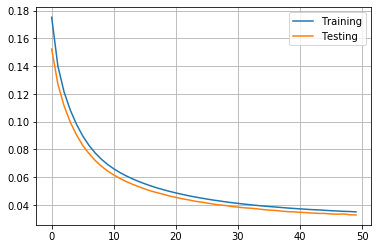

In [14]:
plt.plot(log.history['loss'], label='Training')
plt.plot(log.history['val_loss'], label='Testing')
plt.legend()
plt.grid()

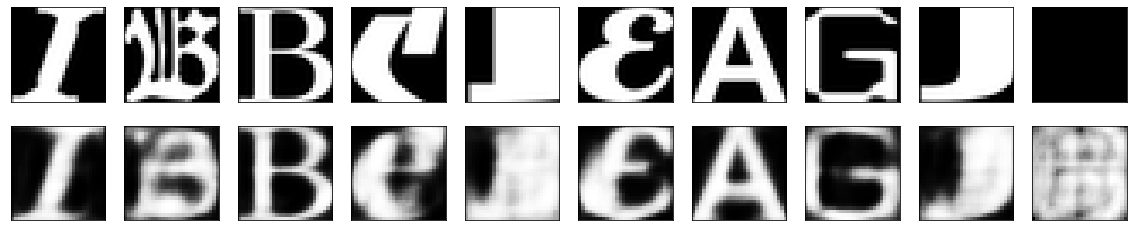

In [15]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(X_test_flat)
decoded_imgs = decoder.predict(encoded_imgs)
plot_result(X_test_flat,decoded_imgs)

### Use the encoded features to train another classifier

In [16]:
X_train_feat = encoder.predict(X_train_flat)
X_test_feat = encoder.predict(X_test_flat)

# Normalization (standardization) of training and test sets
scaler = StandardScaler()  
scaler.fit(X_train_feat)
X_train_feat = scaler.transform(X_train_feat)  
X_test_feat = scaler.transform(X_test_feat)

print(X_train_feat.shape)
print(Y_train.shape)
print(X_test_feat.shape)
print(Y_test.shape)

(6000, 32)
(6000, 10)
(1000, 32)
(1000, 10)


In [17]:
# using the features to train a SVM
clf = SVC(kernel='linear', cache_size=7000)
clf.fit(X_train_feat, train_labels)

SVC(C=1.0, cache_size=7000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [18]:
y_pred = clf.predict(X_test_feat)

# Print classification results with confusion matrix
print("Classification report for classifier %s:\n%s\n" %
      (clf, metrics.classification_report(test_labels, y_pred)))
# print("\nConfusion matrix:\n%s" % metrics.confusion_matrix(test_labels, y_pred))

Classification report for classifier SVC(C=1.0, cache_size=7000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       116
           1       0.90      0.87      0.88       112
           2       0.84      0.96      0.89        89
           3       0.93      0.90      0.92        90
           4       0.88      0.82      0.85        87
           5       0.89      0.91      0.90       105
           6       0.84      0.85      0.84        85
           7       0.90      0.88      0.89       109
           8       0.87      0.79      0.83       106
           9       0.83      0.95      0.89       101

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg

## Create a conv autoencoder

In [30]:
input_img = Input(shape=(28, 28, 1))
# encoder
conv1 = Conv2D(32, kernel_size=(1,1))(input_img) #28 x 28 x 32
pool1 = MaxPooling2D((2,2))(conv1) #14 x 14 x 32
conv2 = Conv2D(64, kernel_size=(1,1))(pool1) #14 x 14 x 64
pool2 = MaxPooling2D((2,2))(conv2) #7 x 7 x 64
conv3 = Conv2D(128, kernel_size=(1,1))(pool2) #7 x 7 x 128 (small and thick)
# decoder
conv4 = Conv2D(128, kernel_size=(1,1))(conv3) #7 x 7 x 128
up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128 (UpSampling2D())
conv5 = Conv2D(64, kernel_size=(1,1))(up1) # 14 x 14 x 64
up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
decoded = Conv2D(1, kernel_size=(1,1))(up2) # 28 x 28 x 1
# autoencoder
autoencoder = Model(inputs=input_img, outputs=decoded)

In [31]:
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 28, 28, 32)        64        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 14, 14, 64)        2112      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 7, 7, 128)         8320      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 7, 7, 128)         1651

In [32]:
log = autoencoder.fit(X_train, X_train, batch_size=32, epochs=50)

Train on 6000 samples
Epoch 1/50
6000/6000 [==============================] - 2s 385us/sample - loss: 0.0706
Epoch 2/50
6000/6000 [==============================] - 1s 179us/sample - loss: 0.0650
Epoch 3/50
6000/6000 [==============================] - 1s 186us/sample - loss: 0.0650
Epoch 4/50
6000/6000 [==============================] - 1s 182us/sample - loss: 0.0650
Epoch 5/50
6000/6000 [==============================] - 1s 184us/sample - loss: 0.0650
Epoch 6/50
6000/6000 [==============================] - 1s 179us/sample - loss: 0.0650
Epoch 7/50
6000/6000 [==============================] - 1s 181us/sample - loss: 0.0650
Epoch 8/50
6000/6000 [==============================] - 1s 181us/sample - loss: 0.0649
Epoch 9/50
6000/6000 [==============================] - 1s 181us/sample - loss: 0.0650
Epoch 10/50
6000/6000 [==============================] - 1s 178us/sample - loss: 0.0650
Epoch 11/50
6000/6000 [==============================] - 1s 179us/sample - loss: 0.0650
Epoch 12/50
6000/60

KeyError: 'val_loss'

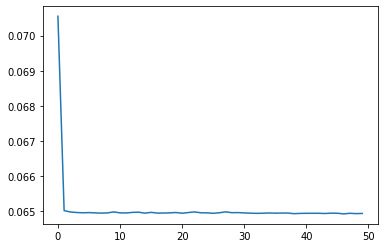

In [33]:
plt.plot(log.history['loss'], label='Training')
plt.plot(log.history['val_loss'], label='Testing')
plt.legend()
plt.grid()

### Predict on test data

In [ ]:
decoded_imgs = autoencoder.predict(X_test, verbose=0)
print(decoded_imgs.shape)

In [ ]:
plot_result(X_test_flat,decoded_imgs)

## Denoising autoencoder
First add some noise.

In [17]:
noise_factor = 0.2 #chose a noise factor between 0.0 and 1.0
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

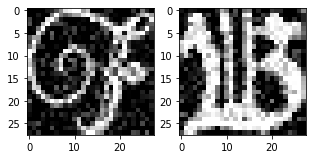

In [23]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(X_train_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(X_test_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

In [19]:
# REDEFINE HERE A CONV AUTOENCODER FOR THE DENOISING WITH A SIMILAR ARCHITECTURE
input_img = Input(shape=(28, 28, 1))
# encoder
conv1 = Conv2D(32, kernel_size=(1,1))(input_img) #28 x 28 x 32
pool1 = MaxPooling2D((2,2))(conv1) #14 x 14 x 32
conv2 = Conv2D(64, kernel_size=(1,1))(pool1) #14 x 14 x 64
pool2 = MaxPooling2D((2,2))(conv2) #7 x 7 x 64
conv3 = Conv2D(128, kernel_size=(1,1))(pool2) #7 x 7 x 128 (small and thick)
# decoder
conv4 = Conv2D(128, kernel_size=(1,1))(conv3) #7 x 7 x 128
up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128 (UpSampling2D())
conv5 = Conv2D(64, kernel_size=(1,1))(up1) # 14 x 14 x 64
up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
decoded = Conv2D(1, kernel_size=(1,1))(up2) # 28 x 28 x 1
# autoencoder
autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        64        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        2112      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 128)         8320      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 128)         1651

In [24]:
# train on the noisy images and use as target the original clean images
log = autoencoder.fit(X_train_noisy, X_train, batch_size=128, epochs=20,
                        verbose=1, validation_data=(X_test_noisy, X_test))

Train on 6000 samples, validate on 1000 samples
Epoch 1/20
6000/6000 [==============================] - 1s 143us/sample - loss: 0.0676 - val_loss: 0.0657
Epoch 2/20
6000/6000 [==============================] - 1s 140us/sample - loss: 0.0676 - val_loss: 0.0657
Epoch 3/20
6000/6000 [==============================] - 1s 152us/sample - loss: 0.0675 - val_loss: 0.0657
Epoch 4/20
6000/6000 [==============================] - 1s 139us/sample - loss: 0.0675 - val_loss: 0.0657
Epoch 5/20
6000/6000 [==============================] - 1s 142us/sample - loss: 0.0675 - val_loss: 0.0657
Epoch 6/20
6000/6000 [==============================] - 1s 140us/sample - loss: 0.0675 - val_loss: 0.0657
Epoch 7/20
6000/6000 [==============================] - 1s 144us/sample - loss: 0.0675 - val_loss: 0.0657
Epoch 8/20
6000/6000 [==============================] - 1s 145us/sample - loss: 0.0675 - val_loss: 0.0657
Epoch 9/20
6000/6000 [==============================] - 1s 148us/sample - loss: 0.0675 - val_loss: 0.065

In [25]:
decoded_imgs = autoencoder.predict(X_test_noisy, verbose=0)
print(decoded_imgs.shape)

(1000, 28, 28, 1)


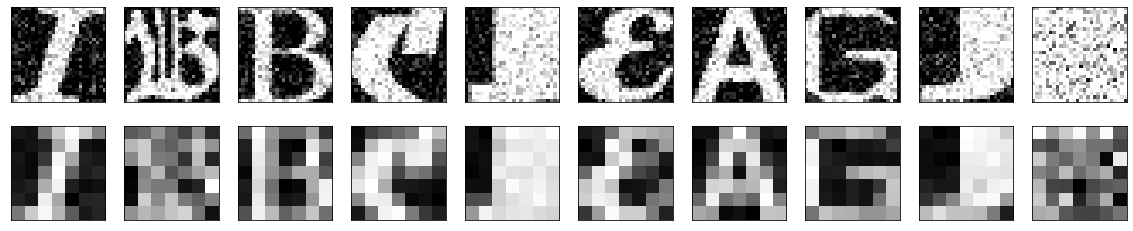

In [26]:
plot_result(X_test_noisy,decoded_imgs)